<a href="https://colab.research.google.com/github/vedanthshenoy/Bacterial-Leaf-Image-Segmentation-using-Mask-RCNN/blob/main/mask_RCNN_bacteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.2.5

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
from os import chdir as cd
cd('/content/drive/MyDrive/Mask_RCNN')
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/model.py to model.cpyt

In [20]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree


In [21]:
class BacteriaConfig(Config):
    # Give the configuration a recognizable name
    NAME = 'bacteria_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = BacteriaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [22]:
class BacteriaDataset(Dataset):
  def load_leaf_scan(self, dataset_dir, subset):
        """dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("bacteria", 1, "bacteria")# Train or validation dataset?
        assert subset in ["train",'test']
        annotations = json.load(open(drive._os.path.join(dataset_dir,subset+'/bacteria_annot.json')))
        annotations = list(annotations.values())  # don't need the dict keys# The VIA tool saves images in the JSON even if they don't have any
        #print(annotations)
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]# Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]# load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = drive._os.path.join(dataset_dir,subset, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "bacteria",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )
            
  def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "bacteria":
            return super(self.__class__, self).load_mask(image_id)# Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1# Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
  def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "bacteria":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [23]:
ROOT_DIR='/content/drive/MyDrive'
MODEL_DIR = drive._os.path.join(ROOT_DIR, 'logs') # directory to save logs and trained model
ANNOTATIONS_DIR = '' # directory with annotations for train/val sets
dataset_dir = '/content/drive/MyDrive' # directory with image data
DEFAULT_LOGS_DIR = 'logs'# Local path to trained weights file
COCO_MODEL_PATH = drive._os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not drive._os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [24]:
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)
model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [25]:
import json
import skimage
dataset_train = BacteriaDataset()
dataset_train.load_leaf_scan('/content/drive/MyDrive/', "train")
dataset_train.prepare()

# Validation dataset
dataset_val = BacteriaDataset()
dataset_val.load_leaf_scan('/content/drive/MyDrive/', "test")
dataset_val.prepare()

model.train(
dataset_train, dataset_val,
learning_rate=config.LEARNING_RATE,
epochs=15,
layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: logs/bacteria_detector20201123T0944/mask_rcnn_bacteria_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/15
100/100 [==============================] - 101s 1s/step - loss: 2.8904 - rpn_class_loss: 0.1365 - rpn_bbox_loss: 0.9767 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.8338 - mrcnn_mask_loss: 0.6790 - val_loss: 2.0728 - val_rpn_class_loss: 0.1581 - val_rpn_bbox_loss: 0.5393 - val_mrcnn_class_loss: 0.2367 - val_mrcnn_bbox_loss: 0.6175 - val_mrcnn_mask_loss: 0.5213

Epoch 2/15
100/100 [==============================] - 64s 644ms/step - loss: 1.8134 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.3533 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.5929 - mrcnn_mask_loss: 0.5187 - val_loss: 2.2769 - val_rpn_class_loss: 0.1600 - val_rpn_bbox_loss: 0.6939 - val_mrcnn_class_loss: 0.2273 - val_mrcnn_bbox_loss: 0.6791 - val_mrcnn_mask_loss: 0.5167
Epoch 3/15
100/100 [==============================] - 64s 641ms/step - loss: 1.6395 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.3309 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.5151 - mrcnn_mask_loss: 0.4773 - val_loss: 2.3696 - val_rpn_

In [26]:
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)
model_path = model.find_last()# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  logs/bacteria_detector20201123T0944/mask_rcnn_bacteria_detector_0015.h5
Re-starting from epoch 15


1
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


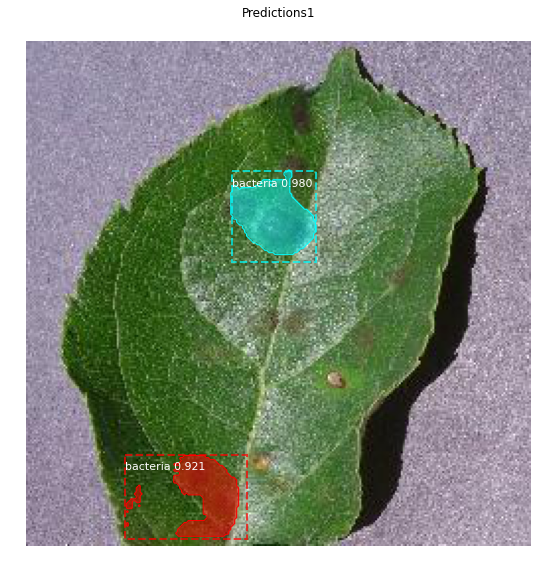

In [30]:
import matplotlib.image as mpimg
def get_ax(rows=1, cols=1, size=10):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
     
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
image1 = mpimg.imread('/content/drive/MyDrive/test/3d34bd1c-fae9-446a-a629-147b5e8d5d6b___FREC_Scab 3103.JPG')
    # Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)
 
    # Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset_val.class_names, r1['scores'], ax=ax,
                            title="Predictions1")

1
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


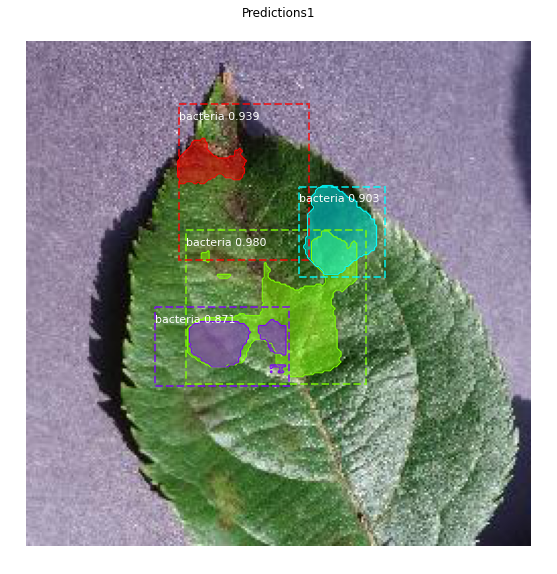

In [28]:
image1 = mpimg.imread('/content/drive/MyDrive/test/3c2f46e3-9f96-4912-a9d5-7a046aa6a1b2___FREC_Scab 2967.JPG')
    # Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)
 
    # Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset_val.class_names, r1['scores'], ax=ax,
                            title="Predictions1")